In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [41]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

In [46]:
year_ago = dt.date.today() - dt.timedelta(days=365)
    
#last_year_data = session.query(Measurement).filter(Measurement.date > year_ago).limit(10)

last_date_query = session.query(Measurement.date).order_by(Measurement.id.desc()).limit(1)

for item in last_date_query:
    last_date = dt.datetime.strptime(item.date, "%Y-%m-%d").date() - dt.timedelta(days=365)

print(last_date)

2016-08-23


In [45]:
# str_date = '2017-08-23'
# date_date = dt.datetime.strptime(str_date, "%Y-%m-%d").date()
# print(date_date)

2017-08-23


In [52]:
my_query = session.query(Measurement.date,Measurement.prcp,Measurement.station).order_by(Measurement.date.desc()).limit(50)
# for item in my_query:
#     print(f"{item.date} - {item.prcp} - {item.station}")

In [64]:
last_year_query = session.query(Measurement.date, func.avg(Measurement.prcp).label('Average')).\
        filter(Measurement.date >= last_date).\
        order_by(Measurement.date.asc()).\
        group_by(Measurement.date)

# for item in last_year_query:
#     print(f"{item.date} - {item.Average}")

In [65]:
dates = [item.date for item in last_year_query]
precipitation = [item.Average for item in last_year_query]

In [71]:
precip_df = pd.DataFrame(precipitation, index=dates, columns=['Avg Precipitation'])
precip_df.head()

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the date and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

,Avg Precipitation
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


Text(0, 0.5, 'Avg Precipitation')

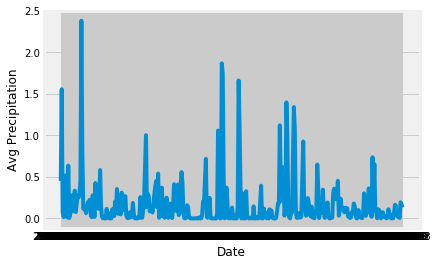

In [80]:
plt.plot(precip_df)
plt.xlabel('Date')
plt.ylabel('Avg Precipitation')

In [15]:
# id INTEGER
# station TEXT
# date TEXT
# prcp FLOAT
# tobs FLOAT


datetime.date(2018, 2, 2)

![precipitation](Images/precipitation.png)

In [81]:
# Use Pandas to calculate the summary statistics for the precipitation data
#assuming this is using the year of data you just created above
#need to correct the query to get 365 days worth of data
precip_df.describe()

,Avg Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


![describe](Images/describe.png)

In [82]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [85]:
# Design a query to show how many stations are available in this dataset?
stations_query = session.query(func.count(Station.id)).all()
stations_query

[(9)]

In [89]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_info = session.query(Measurement.station, func.count(Measurement.station).label('Count')).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).all()
station_info

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [115]:
top_station = station_info[0][0]
top_station

'USC00519281'

In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_info = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs) ).\
    filter(Measurement.station == station_info[0][0]).all()
most_active_info

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [116]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_tobs = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == top_station).all()

observations = list(zip(*most_active_tobs))[1]

(array([ 11.,  26.,  89., 192., 447., 782., 743., 347., 119.,  16.]),
 array([54. , 57.1, 60.2, 63.3, 66.4, 69.5, 72.6, 75.7, 78.8, 81.9, 85. ]),
 <a list of 10 Patch objects>)

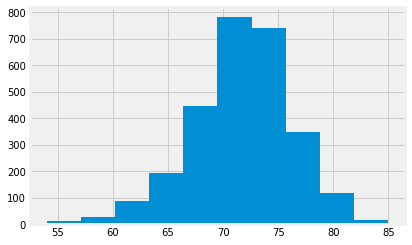

In [99]:
#Confused about which data we're supposed to be running these queries on
plt.hist(observations)

![precipitation](Images/station-histogram.png)

In [100]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = {'start':'2017-05-01', 'end':'2017-05-14'}
my_trip_info = calc_temps(trip['start'], trip['end'])[0]
print(my_trip_info)

(65.0, 75.21794871794872, 80.0)


<BarContainer object of 1 artists>

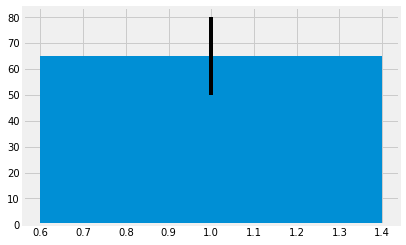

In [114]:
#Add formatting
temp_range = my_trip_info[2] - my_trip_info[0]
plt.bar(1,my_trip_info[0], yerr = temp_range)

<IPython.core.display.Javascript object>


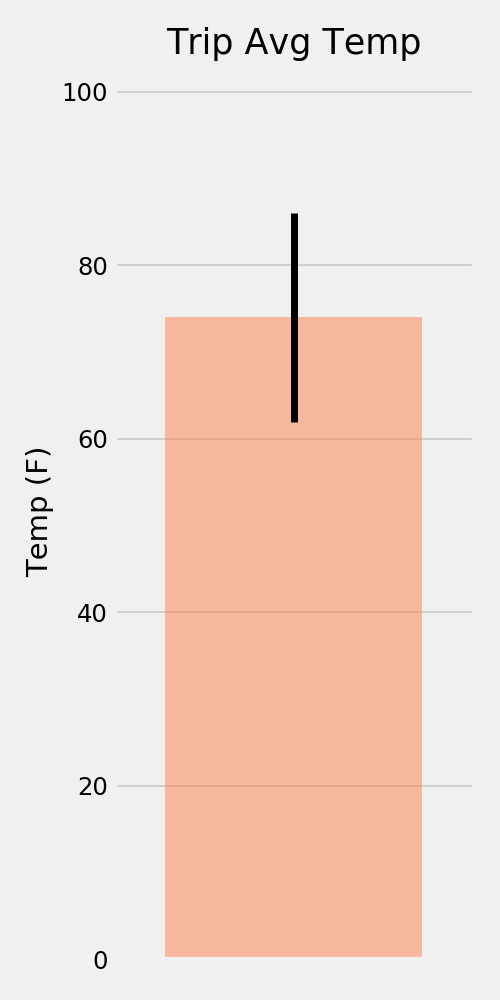

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# id INTEGER
# station TEXT
# name TEXT
# latitude FLOAT
# longitude FLOAT
# elevation FLOAT

In [ ]:
# sel = [EA.family, EA.genus, EA.species, NA.family, NA.genus, NA.species]
# same_sporder = session.query(*sel).filter(EA.sporder == NA.sporder).limit(10).all()

In [122]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('Total Precipitation')]
trip_precip = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('Total Precipitation')).\
        filter(Measurement.date >= trip['start'], Measurement.date <= trip['end'],Station.station == Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).\
        group_by(Station.station).all()

trip_precip


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.9100000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.1100000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.2099999999999995),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.94),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.81),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.27)]

## Optional Challenge Assignment

In [124]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("02-03")

[(58.0, 67.79661016949153, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [159]:
trip_diff = dt.datetime.strptime(trip['end'],"%Y-%m-%d") - dt.datetime.strptime(trip['start'],"%Y-%m-%d")

#use .days to access the days part of the timedelta object
trip_length = trip_diff.days + 1

trip_length

14

In [176]:
the_date = dt.datetime(2017, 5, 1, 0, 0)
string_date = dt.datetime.strftime(the_date,"%Y-%m-%d")
string_date

'2017-05-01'

In [178]:

start_date = dt.datetime.strptime(trip['start'],"%Y-%m-%d")
#list comprehension to generate list of individual days during the trip
trip_range = [start_date + dt.timedelta(days=int(x)) for x in np.arange(trip_length)]
#convert to strings, and format for only month-day
trip_range_str = [dt.datetime.strftime(x,"%m-%d") for x in trip_range]

trip_range_str

['05-01',
 '05-02',
 '05-03',
 '05-04',
 '05-05',
 '05-06',
 '05-07',
 '05-08',
 '05-09',
 '05-10',
 '05-11',
 '05-12',
 '05-13',
 '05-14']

In [180]:
#daily_normals(date)
normals = []

for date in trip_range_str:
    normals.append(daily_normals(date)[0])
    
normals

[(65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0)]

In [183]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = [dt.datetime.strftime(x,"%Y-%m-%d") for x in trip_range]

normals_df = pd.DataFrame(normals,index=trip_dates,columns=['Min','Avg','Max'])

normals_df

,Min,Avg,Max
2017-05-01,65.0,72.759259,79.0
2017-05-02,65.0,73.050847,79.0
2017-05-03,67.0,73.410714,84.0
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0


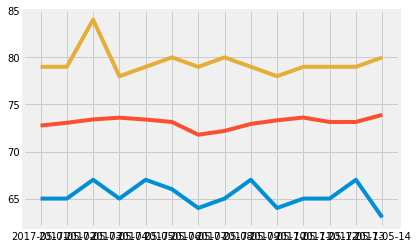

In [190]:
plt.plot(normals_df)

In [191]:
normals_df.index

Index(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04', '2017-05-05',
       '2017-05-06', '2017-05-07', '2017-05-08', '2017-05-09', '2017-05-10',
       '2017-05-11', '2017-05-12', '2017-05-13', '2017-05-14'],
      dtype='object')

Text(0.5, 0, 'Date')

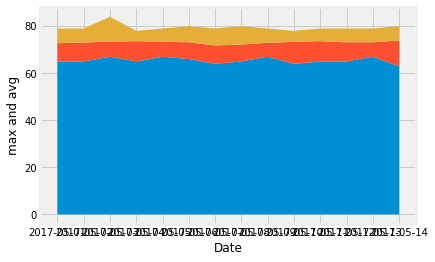

In [195]:
#create an area chart with matplotlib and fill_between
a = normals_df['Min']
b = normals_df['Avg']
c = normals_df['Max']
x = normals_df.index
# fig, ax = plt.subplots()
# ax.plot(normals_df['Min'], label='Min')

# ax.plot(normals_df['Avg'], label='Avg')
# ax.plot(normals_df['Max'], label='Max')

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
# ax1.fill_between(x, 0, y1)
# ax1.set_ylabel('between y1 and 0')

fig, ax = plt.subplots()

ax.fill_between(x, 0, a)
ax.set_ylabel('min and zero')

ax.fill_between(x, a, b)
ax.set_ylabel('avg and min')

ax.fill_between(x, b, c)
ax.set_ylabel('max and avg')
ax.set_xlabel('Date')

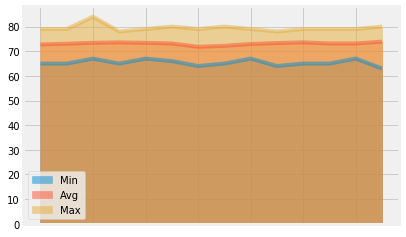

In [197]:
#wow, that's an easy way to create an area chart, using pandas.plot
normals_df.plot.area(stacked=False)

<IPython.core.display.Javascript object>


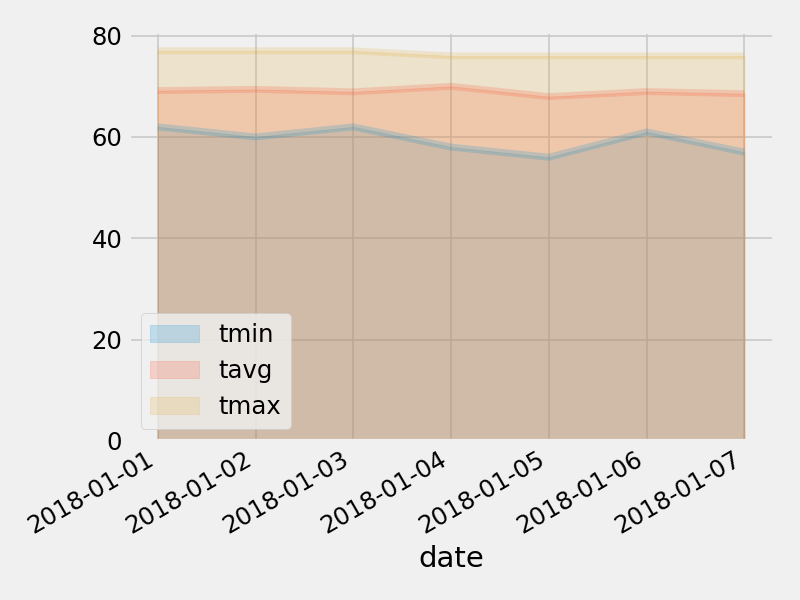

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
